In [1]:
ls ../scotus/data


scotus_filtered.rda


In [2]:
pip install -q pyreadr


[notice] A new release of pip is available: 24.1.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
import torch.nn as nn
import torch
from skorch import NeuralNetRegressor

In [4]:
import pyreadr
result = pyreadr.read_r('../scotus/data/scotus_filtered.rda')

In [5]:
df = result["scotus_filtered"]

# EDA

In [6]:
df["text"].apply(len).describe()

count     10000.000000
mean      25857.630400
std       30323.922087
min        1001.000000
25%        8024.500000
50%       16167.500000
75%       32483.000000
max      761526.000000
Name: text, dtype: float64

In [7]:
df.year

0       1903
1       1987
2       1957
3       1913
4       1826
        ... 
9995    1904
9996    1827
9997    1947
9998    1982
9999    1998
Name: year, Length: 10000, dtype: object

# Embeddings

In [8]:
pip install gensim


[notice] A new release of pip is available: 24.1.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [11]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import pandas as pd


In [ ]:

tagged_data = [TaggedDocument(words=row.split(), tags=[str(idx)]) for idx, row in enumerate(df["text"])]

model = Doc2Vec(
    tagged_data,
    vector_size=100,
    window=5,
    min_count=1,
    workers=4,
    epochs=50
)



In [13]:
df["text_embedding"] = df["text"].apply(lambda x: model.infer_vector(x.split()))

In [14]:
embedding_df = pd.DataFrame(df.text_embedding.tolist(), index= df.index)
embedding_df.to_csv("../scotus_embeddings/doc2vec-scotus_embeddings.csv")

# Train

In [12]:
embedding_df = pd.read_csv("../scotus_embeddings/doc2vec-scotus_embeddings.csv")

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(embedding_df.to_numpy(),df.year.apply(float).to_numpy())

## XGBoost

In [23]:
import xgboost as xg 

clf = xg.XGBRegressor(objective ='reg:squarederror', n_estimators = 100, max_depth=5, seed = 0)
clf.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:

#  XGBRegressori
# XGBRegressor(base_score=None, booster=None, callbacks=None,
#              colsample_bylevel=None, colsample_bynode=None,
#              colsample_bytree=None, device=None, early_stopping_rounds=None,
#              enable_categorical=False, eval_metric=None, feature_types=None,
#              gamma=None, grow_policy=None, importance_type=None,
#              interaction_constraints=None, learning_rate=None, max_bin=None,
#              max_cat_threshold=None, max_cat_to_onehot=None,
#              max_delta_step=None, max_depth=5, max_leaves=None,
#              min_child_weight=None, missing=nan, monotone_constraints=None,
#              multi_strategy=None, n_estimators=500, n_jobs=None,
#              num_parallel_tree=None, random_state=None, ...)

In [24]:
y_pred = clf.predict(X_test)

In [25]:
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error

14.295912770942795


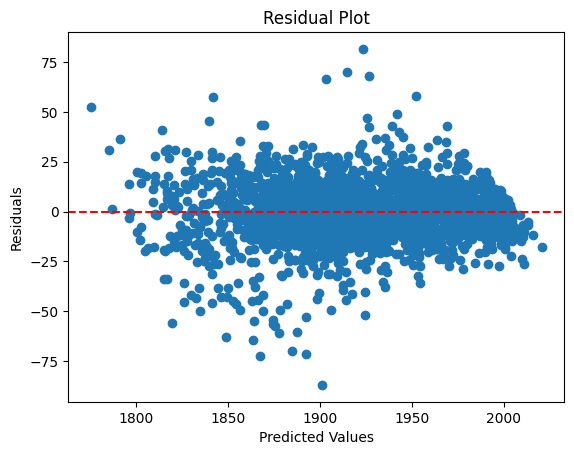

In [26]:
# scale = 1
# y_pred_scale = y_pred / scale
residuals = y_test - y_pred

# filter_idx = (residuals < 1e7) & (residuals > -3e7)
# filter_idx = (residuals < 5e7) & (residuals > -5e7)
# filter_idx = (residuals > -1e5)

# rmse = root_mean_squared_error(y_pred_scale[filter_idx], residuals[filter_idx])
rmse = root_mean_squared_error(y_pred, y_test)
print(rmse)

# residuals[residuals < 5e7]
# Plot the residuals
# plt.scatter(y_pred_scale[filter_idx], residuals[filter_idx])
plt.scatter(y_pred, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

In [21]:
pd.DataFrame(residuals).describe()

,0
count,2500.000000
mean,-0.033817
std,14.745759
min,-161.505371
25%,-7.912964
50%,-0.022583
75%,8.023346
max,111.859985


## MLP

In [27]:
class MLPRegression(nn.Module):
    def __init__(self, input_dim, hidden_dim1=128, hidden_dim2=64, dropout=0.3):
        super(MLPRegression, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim1),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.ReLU(),
            nn.Linear(hidden_dim2, 1)
        )

    def forward(self, x):
        return self.model(x)

In [28]:
input_dim = X_train.shape[1]
net = NeuralNetRegressor(
    MLPRegression,
    module__input_dim=input_dim,
    max_epochs=200,
    lr=0.01,
    optimizer=torch.optim.Adam,
)

param_distributions = {
    'module__hidden_dim1': [64, 128, 256],
    'module__hidden_dim2': [64, 128, 256],
    'module__dropout': [0.1, 0.3, 0.5],
    'lr': [0.001, 0.01, 0.1],
    'batch_size': [32, 64, 128],
}

In [29]:
from sklearn.model_selection import RandomizedSearchCV
# Set up RandomizedSearchCV
search = RandomizedSearchCV(
    estimator=net,
    param_distributions=param_distributions,
    n_iter=20,  # Number of random samples
    scoring='neg_mean_squared_error',
    cv=3,  # 3-fold cross-validation
    verbose=2,
    random_state=42
)


In [30]:
search.fit(X_train.astype('float32'), y_train.astype('float32').reshape(-1, 1))

Fitting 3 folds for each of 20 candidates, totalling 60 fits
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1  1077284.9845   879098.6280  0.1083
      2   745984.4653   453202.7705  0.0830
      3   169291.5524    59752.1752  0.0822
      4    72222.1246    36187.9734  0.0782
      5    65875.2539    42158.9360  0.0851
      6    63280.1053    32723.8056  0.0883
      7    57385.8168    31558.5720  0.0867
      8    55044.1585    26742.4731  0.0814
      9    52855.0661    26900.4405  0.0859
     10    53632.3709    24217.9913  0.0829
     11    51035.2264    23684.3502  0.0793
     12    49862.7927    24479.3078  0.0840
     13    51560.5165    27690.7068  0.0872
     14    48775.0172    22837.3222  0.0842
     15    45231.4558    25964.3770  0.0857
     16    48070.8117    20800.3612  0.0850
     17    49599.6006    31133.8822  0.0827
     18    51942.1712    25944.7592  0.0830
     19    47475.8510    24417.4819  0.0843
     20    4870

RandomizedSearchCV(cv=3,
                   estimator=<class 'skorch.regressor.NeuralNetRegressor'>[uninitialized](
  module=<class '__main__.MLPRegression'>,
  module__input_dim=101,
),
                   n_iter=20,
                   param_distributions={'batch_size': [32, 64, 128],
                                        'lr': [0.001, 0.01, 0.1],
                                        'module__dropout': [0.1, 0.3, 0.5],
                                        'module__hidden_dim1': [64, 128, 256],
                                        'module__hidden_dim2': [64, 128, 256]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [31]:
best_params = search.best_params_
print("Best Parameters:", best_params)

Best Parameters: {'module__hidden_dim2': 256, 'module__hidden_dim1': 256, 'module__dropout': 0.1, 'lr': 0.001, 'batch_size': 128}


In [32]:
hidden_dim1 = best_params['module__hidden_dim1']
hidden_dim2 = best_params['module__hidden_dim2']
dropout = best_params['module__dropout']
lr = best_params['lr']
batch_size = best_params['batch_size']


clf = NeuralNetRegressor(
    MLPRegression,
    module__input_dim=X_train.shape[1],
    module__hidden_dim1=hidden_dim1,
    module__hidden_dim2=hidden_dim2,
    module__dropout=dropout,
    max_epochs=1000,
    lr=lr,
    batch_size=batch_size,
    optimizer=torch.optim.Adam,
    verbose=1
)

clf.fit(X_train.astype('float32'), y_train.astype('float32').reshape(-1, 1))

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1  1152523.4958   938502.5762  0.0885
      2   864113.5078   819549.7113  0.0720
      3   602141.6210   277073.7998  0.0783
      4   102802.7373    48164.4080  0.0721
      5    40784.9160    36605.9504  0.0733
      6    33613.3737    30689.2021  0.0732
      7    30768.5296    28120.6786  0.0715
      8    27870.3306    28916.0796  0.0725
      9    26999.4058    27604.8061  0.0726
     10    25962.6824    25786.2248  0.0774
     11    24356.8039    27982.9331  0.0737
     12    24256.6445    22246.9263  0.0728
     13    23967.1499    23211.5840  0.0754
     14    22160.2926    21433.9096  0.0731
     15    21537.9868    24299.2053  0.0729
     16    21995.6159    23386.3765  0.0737
     17    20512.4847    24646.9710  0.0783
     18    21017.0675    23201.9144  0.0733
     19    19906.5559    17719.4666  0.0707
     20    18998.4776    27280.8764  0.0744
     21    19992.3979    23539.7

<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=MLPRegression(
    (model): Sequential(
      (0): Linear(in_features=101, out_features=256, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.1, inplace=False)
      (3): Linear(in_features=256, out_features=256, bias=True)
      (4): ReLU()
      (5): Linear(in_features=256, out_features=1, bias=True)
    )
  ),
)

In [33]:
y_pred = clf.predict(X_test.astype('float32'))

144.07474101599226


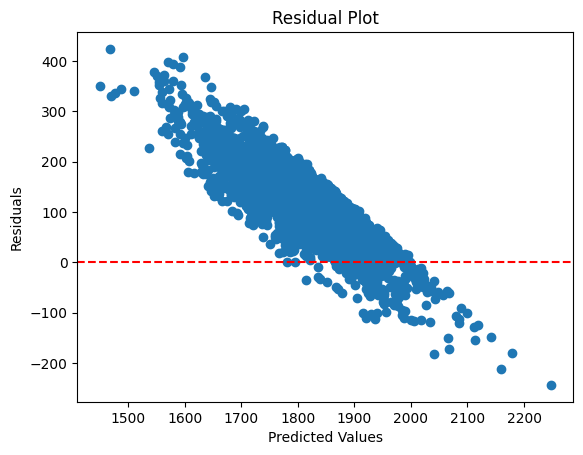

In [34]:

residuals = y_test.reshape(-1, 1) - y_pred

rmse = root_mean_squared_error(y_pred, y_test)
print(rmse)

plt.scatter(y_pred, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y=0, color='r', linestyle='--')

plt.show()

In [35]:
pd.DataFrame(residuals).describe()

,0
count,2500.000000
mean,116.662496
std,84.559169
min,-243.224121
25%,63.773438
50%,115.218994
75%,169.307465
max,423.800049
